<a href="https://colab.research.google.com/github/SaurabhChakravorty/Watch-at-your-own-risk/blob/master/Saurabh_Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Metric Learning

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras import Model
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 , x_test / 255.0

# Add a channel dimension
x_train = x_train[...,tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train,y_train)).shuffle(10000).batch(500)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(500)

In [0]:
class MyModel(Model):
   def __init__(self):
    super(MyModel,self).__init__()
    self.flatten = Flatten()
    self.fc1 = Dense(512, activation='relu')
    self.bn1 = BatchNormalization()
    self.fc2 = Dense(10)
    self.bn2 = BatchNormalization()
    self.fc3 = Dense(10)

   def call(self,x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.fc2(x)
    features = x
    x = tf.nn.relu(x)
    x = self.bn2(x)
    return x, features

model = MyModel()

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [0]:
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions,features = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    return features

@tf.function
def test_step(images,labels):
    predictions,features = model(images, training=False)
    t_loss = loss_object(labels,predictions)

    test_loss(t_loss)
    test_accuracy(labels,predictions)
    return features

In [6]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images,labels in train_ds:
        _ = train_step(images,labels)

    for test_images,test_labels in test_ds:
        _ = test_step(test_images,test_labels)

    template = 'Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1, Loss: 0.556903600692749, Accuracy: 91.00333404541016, Test Loss: 1.5804064273834229, Test Accuracy: 94.68000030517578
Epoch: 2, Loss: 0.30092161893844604, Accuracy: 97.36499786376953, Test Loss: 1.2070584297180176, Test Accuracy: 96.55999755859375
Epoch: 3, Loss: 0.21636369824409485, Accuracy: 98.48999786376953, Test Loss: 0.6584879159927368, Test Accuracy: 97.19999694824219
Epoch: 4, Loss: 0.1625281721353531, Accuracy: 99.12166595458984, Test Loss: 0.3324194550514221, Test Accuracy: 97.959999

In [0]:
train_features = np.zeros((60000,10))
test_features = np.zeros((10000,10))

train_labels_ = np.zeros(60000)
test_labels_ = np.zeros(10000)


for i, (test_images, test_labels) in enumerate(test_ds):
    features = test_step(test_images, test_labels)
    features = tf.make_tensor_proto(features)
    features = tf.make_ndarray(features)
    test_features[i*500:i*500+500] = features

    test_labels = tf.make_tensor_proto(test_labels)
    test_labels = tf.make_ndarray(test_labels)
    test_labels_[i*500:i*500+500] = test_labels


for i, (train_images, train_labels) in enumerate(train_ds):
    features = test_step(train_images, train_labels)
    features = tf.make_tensor_proto(features)
    features = tf.make_ndarray(features)
    train_features[i*500:i*500+500] = features

    train_labels = tf.make_tensor_proto(train_labels)
    train_labels = tf.make_ndarray(train_labels)
    train_labels_[i*500:i*500+500] = train_labels 

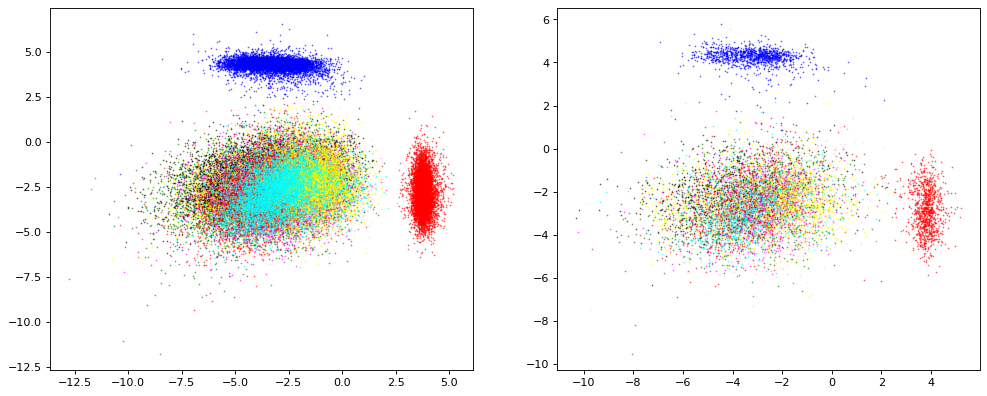

In [8]:
figure(num=None, figsize=(15,6),dpi=80,facecolor='w',edgecolor='k')
clr = ['red','blue','green','yellow','black','magenta','pink','red','yellow','cyan']
plt.subplot(121)
for i in range(10):
    plt.scatter(train_features[train_labels_ == i].T[0],
                train_features[train_labels_ == i].T[1],
                c=clr[i],s=.1)

plt.subplot(122)
for i in range(10):
    plt.scatter(test_features[test_labels_ == i].T[0],
                test_features[test_labels_ == i].T[1],
                c=clr[i],s=.1)    


## Siamese Network

In [0]:
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions,features = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    return features

@tf.function
def test_step(images,labels):
    predictions,features = model(images, training=False)
    t_loss = loss_object(labels,predictions)

    test_loss(t_loss)
    test_accuracy(labels,predictions)
    return features

In [0]:
class MyModel(Model):
   def __init__(self):
    super(MyModel,self).__init__()
    self.conv1 = Conv2D(16,5,activation='relu')
    self.bn1 = BatchNormalization()
    self.conv2 = Conv2D(16,5,activation='relu')
    self.bn2 = BatchNormalization()
    self.flatten = Flatten()
    self.fc1 = Dense(512, activation='relu')
    self.bn3 = BatchNormalization()
    self.fc2 = Dense(2)
    self.bn4 = BatchNormalization()
    self.fc3 = Dense(10)

   def call(self,x):
    x = self.conv1(x)
    x = MaxPool2D()(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = MaxPool2D()(x)
    x = self.bn2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.fc2(x)
    x = self.bn4(x)
    features = x
    x = tf.nn.relu(x)
    x = self.fc3(x)
    return x, features

model = MyModel()

In [11]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images,labels in train_ds:
        _ = train_step(images,labels)

    for test_images,test_labels in test_ds:
        _ = test_step(test_images,test_labels)

    template = 'Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1, Loss: 1.75132155418396, Accuracy: 32.46833419799805, Test Loss: 2.1366353034973145, Test Accuracy: 13.84000015258789


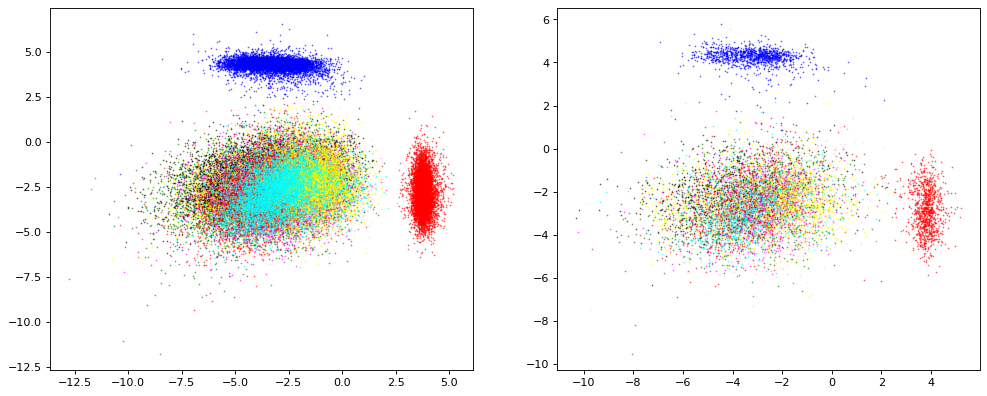

In [12]:
figure(num=None, figsize=(15,6),dpi=80,facecolor='w',edgecolor='k')
clr = ['red','blue','green','yellow','black','magenta','pink','red','yellow','cyan']
plt.subplot(121)
for i in range(10):
    plt.scatter(train_features[train_labels_ == i].T[0],
                train_features[train_labels_ == i].T[1],
                c=clr[i],s=.1)

plt.subplot(122)
for i in range(10):
    plt.scatter(test_features[test_labels_ == i].T[0],
                test_features[test_labels_ == i].T[1],
                c=clr[i],s=.1)    


In [0]:
class Dataset(object):
    images_train = np.array([])
    images_test = np.array([])
    labels_train = np.array([])
    labels_test = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def _get_siamese_similar_pair(self):
        label = np.random.choice(self.unique_train_label)
        l,r   = np.random.choice(self.map_train_label_indices[label], 2, replace=True)
        return l,r,1

    def _get_siamese_dissimilar_pair(self):
        label_l,label_r   = np.random.choice(self.unique_train_label, 2, replace=True)
        l = np.random.choice(self.map_train_label_indices[label_l])
        r = np.random.choice(self.map_train_label_indices[label_r])
        return l,r,0

    def _get_siamese_pair(self):
        if np.random.random() < 0.5:
            return self._get_siamese_similar_pair()
        else:
            return self._get_siamese_dissimilar_pair()

    def get_siamese_batch(self,n):
        idxs_left, idxs_right, labels = [],[],[]
        for _ in range(n):
            l ,r ,x = self._get_siamese_pair()
            idxs_left.append(l)
            idxs_right.append(r)
            labels.append(x)
        return self.images_train[idxs_left,:],self.images_train[idxs_right,:],np.expand_dims(labels,axis=1)

class MNISTDataset(Dataset):
    def __init__(self):
        print("===Loading MNIST Dataset===")
        (self.images_train, self.labels_train),(self.images_test, self.labels_test) = mnist.load_data()
        self.images_train = np.expand_dims(self.images_train, axis = 3) / 255.0
        self.images_test  = np.expand_dims(self.images_test, axis = 3) / 255.0
        self.labels_train = np.expand_dims(self.labels_train, axis = 1)
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in self.unique_train_label}
        print("Images train : ", self.images_train.shape)
        print("Labels train : ", self.labels_train.shape)
        print("Images test : ", self.images_test.shape)
        print("Labels test : ", self.labels_test.shape)
        print("Unique label : ", self.unique_train_label)


In [14]:
train_ds = MNISTDataset()

===Loading MNIST Dataset===
Images train :  (60000, 28, 28, 1)
Labels train :  (60000, 1)
Images test :  (10000, 28, 28, 1)
Labels test :  (10000,)
Unique label :  [0 1 2 3 4 5 6 7 8 9]


In [0]:
class MyModel(Model):
   def __init__(self):
    super(MyModel,self).__init__()
    self.flatten = Flatten()
    self.fc1 = Dense(256, activation='relu')
    self.bn1 = BatchNormalization()
    self.fc2 = Dense(64, activation='relu')
    self.bn2 = BatchNormalization()
    self.fc3 = Dense(10)

   def call(self,x,y):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.fc3(x)

    y = self.flatten(y)
    y = self.fc1(y)
    y = self.bn1(y)
    y = self.fc2(y)
    y = self.bn2(y)
    y = self.fc3(y)

    return x,y
model = MyModel()

In [16]:
train_ds = MNISTDataset()

next_batch = train_ds.get_siamese_batch

EPOCHS = 10
margin = 1.
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        x, y, labels = next_batch(2048)
        labels = tf.squeeze(tf.cast(tf.convert_to_tensor(labels),tf.float32), axis=1)
        x_, y_ = model(x,y)
        distances = tf.reduce_sum(tf.math.pow((x_ - y_), 2), axis = 1)
        loss = labels * distances
        loss += (1 + -1 * labels) * tf.nn.relu(margin - tf.math.pow(tf.math.sqrt(distances), 2))
        loss = tf.reduce_sum(loss)
        if epoch%10 == 0: print(loss)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


===Loading MNIST Dataset===
Images train :  (60000, 28, 28, 1)
Labels train :  (60000, 1)
Images test :  (10000, 28, 28, 1)
Labels test :  (10000,)
Unique label :  [0 1 2 3 4 5 6 7 8 9]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, 

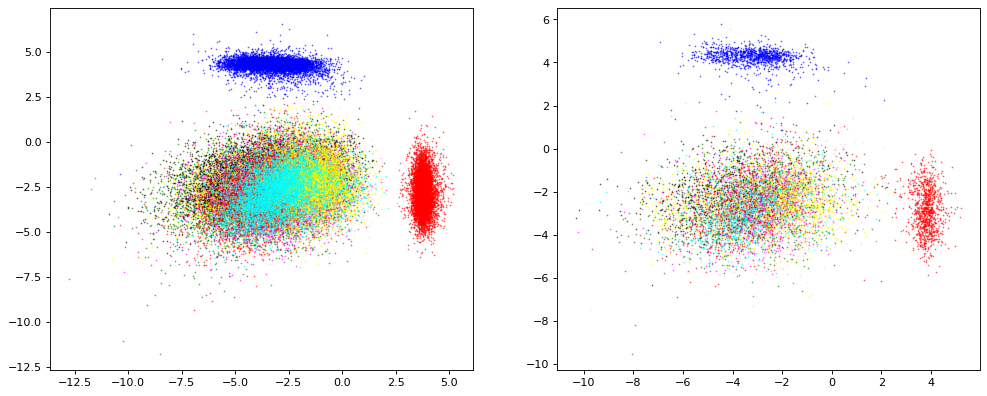

In [17]:
figure(num=None, figsize=(15,6),dpi=80,facecolor='w',edgecolor='k')
clr = ['red','blue','green','yellow','black','magenta','pink','red','yellow','cyan']
plt.subplot(121)
for i in range(10):
    plt.scatter(train_features[train_labels_ == i].T[0],
                train_features[train_labels_ == i].T[1],
                c=clr[i],s=.1)

plt.subplot(122)
for i in range(10):
    plt.scatter(test_features[test_labels_ == i].T[0],
                test_features[test_labels_ == i].T[1],
                c=clr[i],s=.1)    


## Triplet Network

In [0]:
class Dataset(object):
    images_train = np.array([])
    images_test = np.array([])
    labels_train = np.array([])
    labels_test = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def _get_triplet(self):
        label_l,label_r = np.random.choice(self.unique_train_label, 2, replace=False)
        anchor = np.random.choice(self.map_train_label_indices[label_l])
        pos = np.random.choice(self.map_train_label_indices[label_l])
        neg = np.random.choice(self.map_train_label_indices[label_r])
        return anchor,pos,neg



    def get_triplet_batch(self,n):
        anchors,pos_images,neg_images = [],[],[]
        for _ in range(n):
            anchor,pos,neg = self._get_triplet()
            anchors.append(anchor)
            pos_images.append(pos)
            neg_images.append(neg)
        return self.images_train[anchors,:],self.images_train[pos_images,:],self.images_train[neg_images,:]

class MNISTDataset(Dataset):
    def __init__(self):
        print("===Loading MNIST Dataset===")
        (self.images_train, self.labels_train),(self.images_test, self.labels_test) = mnist.load_data()
        self.images_train = np.expand_dims(self.images_train, axis = 3) / 255.0
        self.images_test  = np.expand_dims(self.images_test, axis = 3) / 255.0
        self.labels_train = np.expand_dims(self.labels_train, axis = 1)
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in self.unique_train_label}
        print("Images train : ", self.images_train.shape)
        print("Labels train : ", self.labels_train.shape)
        print("Images test : ", self.images_test.shape)
        print("Labels test : ", self.labels_test.shape)
        print("Unique label : ", self.unique_train_label)


In [0]:
class MyModel(Model):
   def __init__(self):
    super(MyModel,self).__init__()
    self.flatten = Flatten()
    self.fc1 = Dense(256, activation='relu')
    self.bn1 = BatchNormalization()
    self.fc2 = Dense(64, activation='relu')
    self.bn2 = BatchNormalization()
    self.fc3 = Dense(10)

   def call(self,anchor,pos,neg):
    anchor = self.flatten(anchor)
    anchor = self.fc1(anchor)
    anchor = self.bn1(anchor)
    anchor = self.fc2(anchor)
    anchor = self.bn2(anchor)
    anchor = self.fc3(anchor)

    pos = self.flatten(pos)
    pos = self.fc1(pos)
    pos = self.bn1(pos)
    pos = self.fc2(pos)
    pos = self.bn2(pos)
    pos = self.fc3(pos)

    neg = self.flatten(neg)
    neg = self.fc1(neg)
    neg = self.bn1(neg)
    neg = self.fc2(neg)
    neg = self.bn2(neg)
    neg = self.fc3(neg)

    return anchor,pos,neg



In [0]:
model = MyModel()

In [21]:
train_ds = MNISTDataset()

next_batch = train_ds.get_triplet_batch

EPOCHS = 100
margin = 1.
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        anchor,pos,neg = next_batch(2048)
        anchor_,pos_,neg_ = model(anchor,pos,neg)
      
        distance_pos = tf.reduce_sum(tf.math.pow(anchor_ - pos_, 2), axis = 1)
        distance_neg = tf.reduce_sum(tf.math.pow(anchor_ - neg_, 2), axis = 1)
        loss = tf.nn.relu(distance_pos -distance_neg  + margin )
        loss = tf.reduce_sum(loss)
        if epoch%10 == 0: print(loss)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


===Loading MNIST Dataset===
Images train :  (60000, 28, 28, 1)
Labels train :  (60000, 1)
Images test :  (10000, 28, 28, 1)
Labels test :  (10000,)
Unique label :  [0 1 2 3 4 5 6 7 8 9]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, 

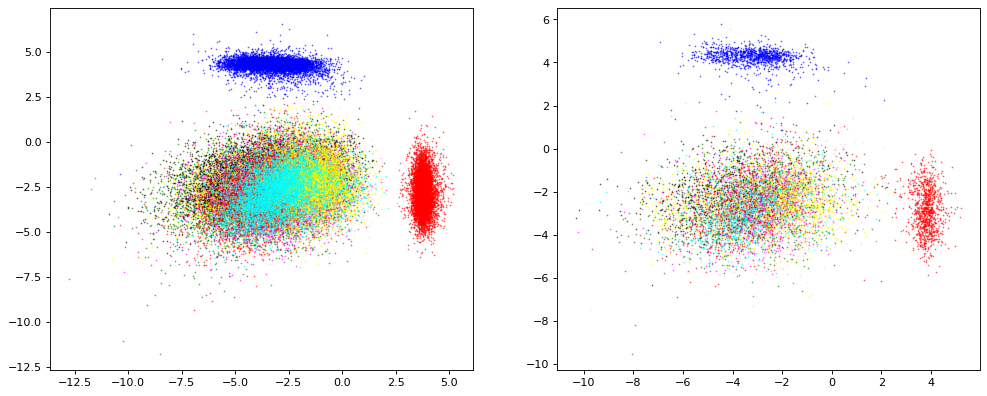

In [22]:
figure(num=None, figsize=(15,6),dpi=80,facecolor='w',edgecolor='k')
clr = ['red','blue','green','yellow','black','magenta','pink','red','yellow','cyan']
plt.subplot(121)
for i in range(10):
    plt.scatter(train_features[train_labels_ == i].T[0],
                train_features[train_labels_ == i].T[1],
                c=clr[i],s=.1)

plt.subplot(122)
for i in range(10):
    plt.scatter(test_features[test_labels_ == i].T[0],
                test_features[test_labels_ == i].T[1],
                c=clr[i],s=.1)    
